In [2]:
from mm import *

In [16]:
from dataclasses import dataclass

In [3]:
def query(q,url='http://85.193.83.20:8123',format=True,**kwargs):
    if format:
        return pd.read_csv(BytesIO(r.post(url=url,
                data=(q+'\nFORMAT CSVWithNames').encode('utf-8'),
                auth= (os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD'))
                ).content),**kwargs)
    
    else:
        return r.post(url=url,
                data=q.encode('utf-8'),
                auth=(os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD')))
    

In [13]:
def rsi_calc(df,w=14):
    wsa = (100 - 100 / df.pct_change().where(lambda x: x>0).rolling(w,1).mean().div(df.pct_change().where(lambda x: x<0).rolling(w,1).mean().abs()).add(1))
    rsi = wsa.shift(1).mul(w-1).add(wsa).div(w)
    return rsi

In [97]:
qq = query('''
select toStartOfInterval(toDateTime(trade_time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancews_trade
where t>'2022-01-21'
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [330]:
@dataclass
class TradeBot:
    name : str = 'Vasya'
    deposit : int = 100000
    trade_fee : float = .001
    profit : float = .001
    stoploss : float = 0.05

    buy_dict = {}
    deals_dict = {'sell':[],'buy':[]}

    def get_data(self,df):
        self.df = df.iloc[-60:]
        self.current_price = df[-1]
        self.current_dt = df.index[-1]

    def check_rsi(self):
        self.last_rsi_value = rsi_calc(self.df)[-1]
        return self.last_rsi_value
    
    def check_buy(self):

        if self.check_rsi()<10 :
            self.buy_dict[self.current_dt] = self.current_price*(1 - self.trade_fee)
            self.deposit -= self.current_price*(1 - self.trade_fee)
            self.deals_dict['buy'].append(self.current_dt)
        return self


    def check_sell(self,order):
        profit_pct = self.profit + self.trade_fee
        if self.current_price / self.buy_dict[order] > 1 + profit_pct:
            self.deposit += self.current_price*(1 - self.trade_fee)
            self.deals_dict['sell'].append(self.current_dt)
            del self.buy_dict[order]

        elif self.current_price / self.buy_dict[order] < 1 - self.stoploss:
            self.deposit += self.current_price*(1 - self.trade_fee)
            self.deals_dict['sell'].append(self.current_dt)
            del self.buy_dict[order]

        return self



    def fetch_deals(self):

        tmp_dict = list(self.buy_dict.keys())
        
        for i in tmp_dict:
            self.check_sell(i)

        if self.deposit > self.current_price:
            self.check_buy()

        return self
    

In [331]:
zz = TradeBot(name = 'Oleg',stoploss=.03,profit=.01)
for i in range(1,5000):

    zz.get_data(qq['avg_price'].iloc[:i])
    zz.fetch_deals()

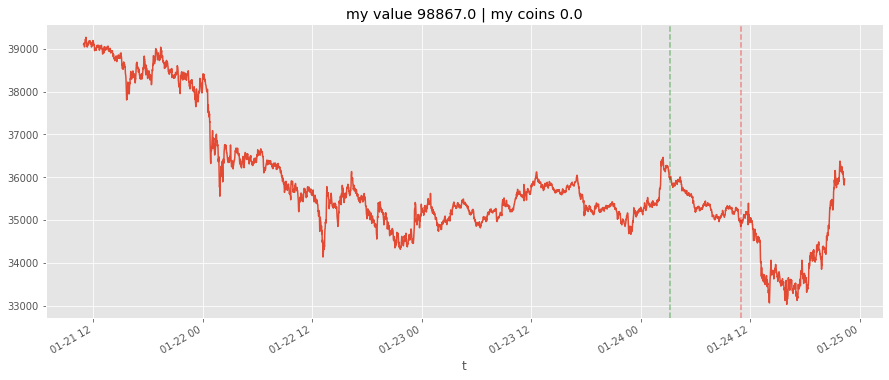

In [332]:
qq['avg_price'].iloc[:5000].plot(title=f'my value {zz.deposit:.1f} | my coins {np.sum(list(zz.buy_dict.values()))}')
[plt.axvline(dt,linestyle='--',color='g',alpha=.4) for dt in zz.deals_dict['buy']];
[plt.axvline(dt,linestyle='--',color='r',alpha=.4) for dt in zz.deals_dict['sell']];


<AxesSubplot:xlabel='t'>

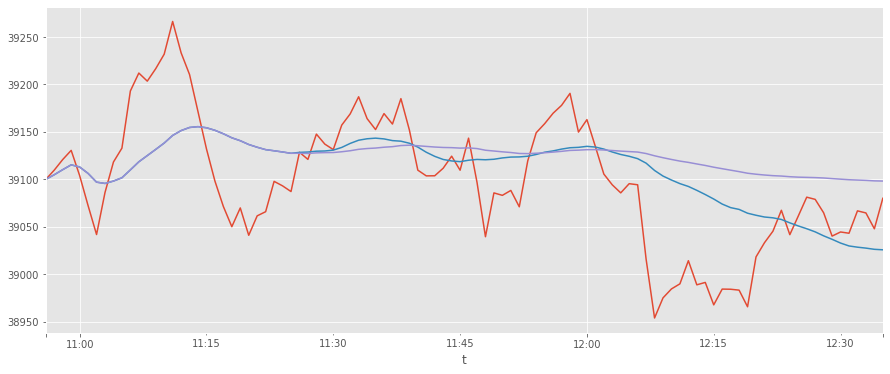

In [336]:
qq['avg_price'].iloc[:100].plot()
qq['avg_price'].iloc[:100].rolling(30,1).mean().plot()
qq['avg_price'].iloc[:100].rolling(100,1).mean().plot()